In [2]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, ".")

import asyncio
from src.main import run_round, load_data, save_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
west = [
    "gonzaga",
    "duke",
    "texas_tech",
    "ohio_state", # 4
    "uconn",
    "usc",
    "michigan_state",
    "colorado_state", # 8
    "miami",
    "creighton",
    "davidson",
    "iona", # 12
    "toledo",
    "texas_state",
    "yale",
    ["texas_southern", "new_orleans"] # 16
]
east = [
    "auburn",
    "purdue",
    "villanova",
    "ucla", # 4
    "houston",
    "lsu",
    "iowa_state",
    "xavier", # 8
    "notre_dame",
    "wake_forest",
    ["loyola_chicago", "memphis"],
    ["san_francisco", "indiana"], # 12
    "vermont",
    "wagner",
    "colgate",
    ["longwood", "norfolk_state"], # 16
]

south = [
    "arizona",
    "baylor",
    "tennesee",
    "illinois", # 4
    "texas",
    "iowa",
    "boise_state",
    "seton_hall", # 8
    "wyoming",
    "rutgers",
    "north_carolina",
    "south_dakota_state", # 12
    "chattanooga",
    "northern_iowa",
    "long_beach_state",
    "unc_wilmington", # 16
]

midwest = [
    "kansas",
    "kentucky",
    "wisconsin",
    "providence", # 4
    "alabama",
    "arkansas",
    "marquette",
    "saint_marys", # 8
    "murray_state",
    "michigan",
    "tcu",
    "north_texas", # 12
    "new_mexico_state",
    "montana_state",
    "jacksonville_state",
    "cleveland_state", # 16
]



In [ ]:
west_df = pd.DataFrame({
    'team_name': west,
    'seed': range(1, 17),
    'effective_seed': range(1, 17),
    'region': 'west',
    'round': 1,
})
west_df = west_df.set_index("effective_seed")

In [ ]:
west_df.to_csv("data/west_1.csv")

In [ ]:
regions = ["west", "south", "midwest", "east"]

def safe_loads(s):
    try:
        return json.loads(s.replace('\'', '"'))
    except:
        return s

def load_data(region, rnd):
    if rnd < 5:
        df = pd.read_csv(f'data/{region}_{rnd}.csv')
    elif rnd == 5:
        df = pd.concat([pd.read_csv(f'data/{r}_{rnd}.csv') for r in regions])
    elif rnd == 6:
        df = pd.read_csv("data/final.csv")
    else:
        df = pd.read_csv("data/champion.csv")
    
    df = df.set_index("effective_seed")
    df["team_name"] = df["team_name"].map(lambda x: safe_loads(x))
    return df

def save_data(df, region, rnd):
    if rnd < 6:
        df.to_csv(f'data/{region}_{rnd}.csv')
    elif rnd == 6:
        df.to_csv("data/final.csv")
    else:
        df.to_csv("data/champion.csv")

def prettify(s):
    if isinstance(s, list):
        s = str(s)
    return s.upper().replace('_', ' ')

def uglify(s):
    return s.lower().replace(' ', '_')

def show_images(teams):
    fig,ax = plt.subplots(1, 2, figsize=(15,15))

    for i, team in enumerate(teams):
        with open(f'imgs/{team}.jpg','rb') as f:
            image=Image.open(f)
            ax[i].axis('off')
            ax[i].set_title(prettify(team), size=20)
            ax[i].imshow(image)
    plt.axis('off')
    fig.show()
    plt.show()

def make_buttons(teams):
    button_names = teams + ['Random']
    options = widgets.ToggleButtons(
        options=[prettify(x) for x in button_names],
    )
    submit = widgets.Button(
        description='Submit',
        icon='check'
    )

    display(options)
    display(submit)
    
    return options, submit

def get_effective_seed(top_seed, region, rnd):
    if rnd != 4:
        return top_seed.name

    return regions.index(region) + 1

def process_random(teams):
    x = random()
    if x < 0.5:
        return teams[0]
    else:
        return teams[1]

def wait_for_change(options, submit):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(options.value)
    submit.on_click(getvalue)
    return future

In [ ]:
async def run_round(rnd):
    if rnd < 5:
        round_regions = regions
    else:
        round_regions = [None]
    
    for region in round_regions:
        df = load_data(region, rnd)
        next_df = pd.DataFrame()

        if rnd < 5:
            max_seed = 2**(5-rnd)
        elif rnd == 5:
            max_seed = 4
        else:
            max_seed = 2

        for i in range(1, max_seed//2 + 1):
            top_seed = df.loc[i]
            bot_seed = df.loc[max_seed + 1 - i]

            top_teams = top_seed["team_name"] if isinstance(top_seed["team_name"], list) else [top_seed["team_name"]]
            bot_teams = bot_seed["team_name"] if isinstance(bot_seed["team_name"], list) else [bot_seed["team_name"]]

            winners = []
            for top_team, bot_team in product(top_teams, bot_teams):

                teams = [top_team, bot_team]

                show_images(teams)
                options, submit = make_buttons(teams)

                choice = await wait_for_change(options, submit)
                print(choice)

                if choice == prettify("Random"):
                    winner = process_random(teams)
                    print(f"Selected: {winner}")
                    time.sleep(4)
                else:
                    winner = choice

                time.sleep(1)

                winners.append(winner)

            if len(set(winners)) == 1:
                winners = uglify(winners[0])
            else:
                winners = [uglify(x) for x in winners]

            clear_output()

            winner_df = pd.DataFrame({
                'team_name': [winners],
                'seed': top_seed["seed"] if prettify(top_seed["team_name"]) == winner else bot_seed["seed"],
                'effective_seed': get_effective_seed(top_seed, region, rnd),
                'region': region,
                'round': rnd + 1,
            })

            next_df = pd.concat([next_df, winner_df])

        save_data(next_df, region, rnd + 1)
        print(f"Done with region: {region}, round: {rnd}")
    
    time.sleep(10)

<Task pending coro=<run_round() running at ./src/main.py:101>>

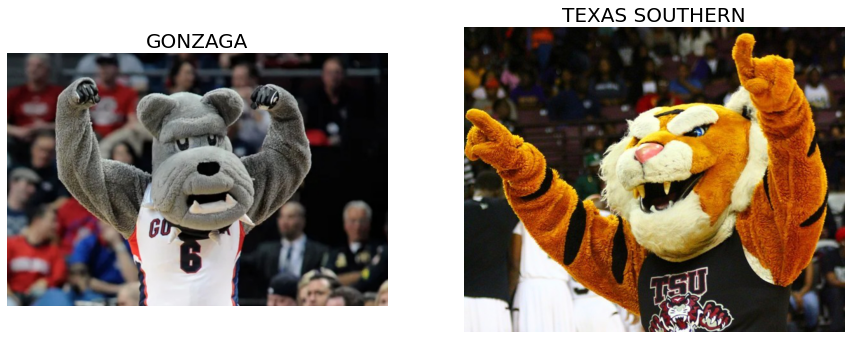

ToggleButtons(options=('GONZAGA', 'TEXAS SOUTHERN', 'RANDOM'), value='GONZAGA')

Button(description='Submit', icon='check', style=ButtonStyle())

In [2]:
asyncio.create_task(run_round(1))

In [ ]:
df2 = load_data("west", 7)

In [ ]:
df2